In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('drive/MyDrive/NLP_Project/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

drive/MyDrive/NLP_Project/archive/twitter_training.csv
drive/MyDrive/NLP_Project/archive/twitter_validation.csv


In [3]:
import torch
import re
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
test_df = pd.read_csv('drive/MyDrive/NLP_Project/archive/twitter_validation.csv', header=None)
train_df = pd.read_csv('drive/MyDrive/NLP_Project/archive/twitter_training.csv', header=None)

test_df.reset_index(drop=True,inplace=True)
train_df.reset_index(drop=True,inplace=True)

df = pd.concat([train_df,test_df], axis=0)
df.drop([0], axis=1, inplace=True)
df.columns = ['platform','sentiment','text']

In [5]:
df.drop(['platform'], axis=1, inplace=True)
df.sentiment = df.sentiment.map({"Neutral":0, "Irrelevant":0 ,"Positive":1,"Negative":2})
df.dropna(inplace=True)

In [6]:
def clean_text(text):
    if isinstance(text, str):
        # Remove numbers
        text = re.sub(r'\d+', '', text)

        # Remove special characters
        str_text = re.sub(r'[^\w\s]', '', text)

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        tokens = str_text.lower().split()
        str_text = ' '.join([word for word in tokens if word not in stop_words])
        return str_text
    else:
        return text

In [7]:
df["text"] = df['text'].apply(clean_text)

In [8]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = df.sentiment.values)

In [11]:
import gc
del df
gc.collect()

60

In [12]:
train_df

,sentiment,text
33472,0,gonna make diluc fortnite dances watch
32930,0,nigga kill fartnite endt gun chashed two minut...
51119,0,happens gg man one funniest fifa youtubers
49867,2,nice play garbage ps ps
34514,0,incredible achievement congratulations kinda s...
...,...,...
54782,1,nothing disappointing
12708,2,dont play game wth
35529,2,billgates bro opp tryna play good guy dont nee...
15878,2,rarely still irritating reddit epexr


In [13]:
encoder_train = tokenizer.batch_encode_plus(train_df.text.values,
                                           add_special_tokens = True,
                                            return_attention_mask = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(test_df.text.values,
                                           add_special_tokens = True,
                                            return_attention_mask = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(train_df.sentiment.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test_df.sentiment.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [15]:
len(data_train),len(data_test)

(59996, 15000)

In [16]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
#                                      num_labels = 3,
#                                      output_attentions = False,
#                                      output_hidden_states =  False)

In [17]:
#Load from pretrain model
import torch
from transformers import BertForSequenceClassification, BertConfig
config = BertConfig.from_pretrained('bert-base-uncased',
                                    num_labels=3,
                                    output_attentions=False,
                                    output_hidden_states=False)

model = BertForSequenceClassification(config)
model_path = 'drive/MyDrive/NLP_Project/bert_base_model.pth'
model.bert.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader
dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16

)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32

)

In [19]:
from sklearn.metrics import f1_score, accuracy_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')

def acc(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [20]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")
model

Loading:cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions,true_vals = [],[]

    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals


In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 3
total_steps = len(dataloader_train) * epochs

warmup_steps = total_steps * 0.1

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
training_loss = []
validation_loss = []
testScore = []
test_acc = []
for epoch in tqdm(range(1,epochs+1)):
    model.train()

    loss_train_total=0

    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)


    for batch in progress_bar:
        train_acc = 0.0
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]

        }
        outputs = model(**inputs)

        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

        optimizer.step()
        scheduler.step()


        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})

    tqdm.write(f'Epoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    training_loss.append(loss_train_avg)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    test_accuracy = acc(predictions, true_vals)
    validation_loss.append(val_loss)
    testScore.append(test_score)
    test_acc.append(test_accuracy)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score} \n Test Accuracy:{test_accuracy}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-25-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 1
Training Loss: 0.7404566197077433


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.47532440772824197
 Test Score:0.812248763732827 
 Test Accuracy:0.8124


Epoch: 2:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-25-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 2
Training Loss: 0.340688208497564


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.3171407764058695
 Test Score:0.8921764955652033 
 Test Accuracy:0.8924666666666666


Epoch: 3:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-25-26550d2252a7>:31: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)


Epoch 3
Training Loss: 0.17315508457366377


  0%|          | 0/469 [00:00<?, ?it/s]

Val Loss:0.3174439016615412
 Test Score:0.91040518406965 
 Test Accuracy:0.9105333333333333


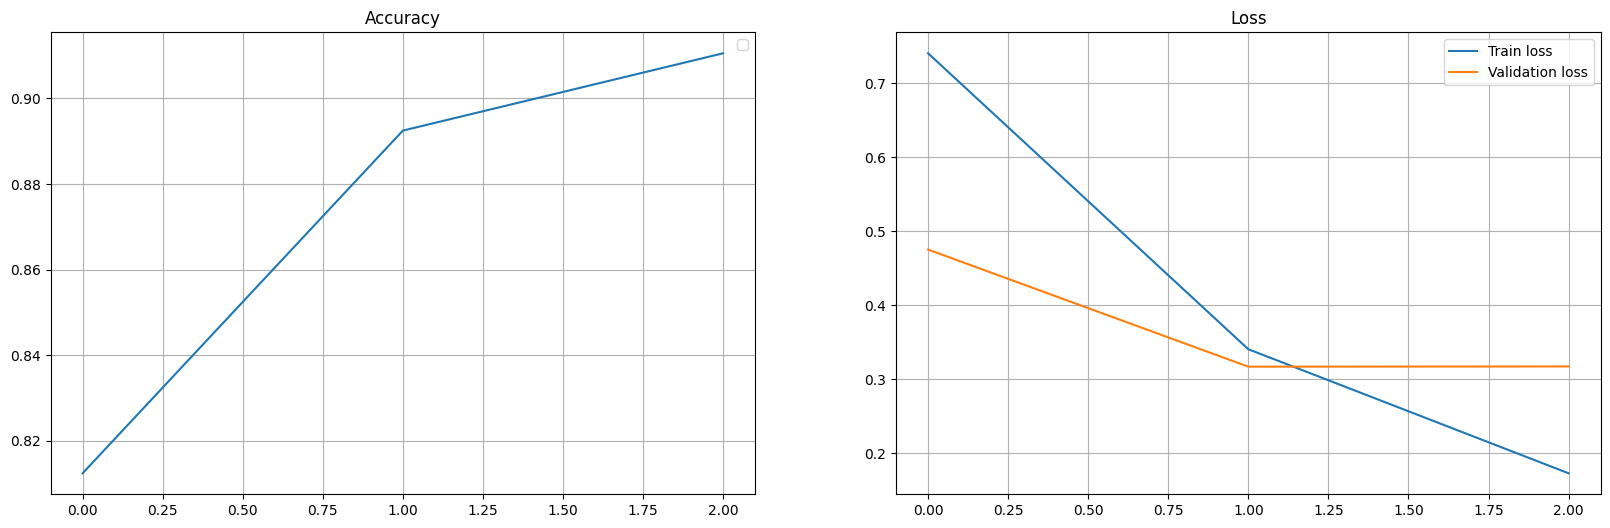

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(test_acc)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [1]:
# torch.save(model.bert.state_dict(), 'bert_base_model.pth')

NameError: name 'torch' is not defined